In [1]:
import numpy as np
import random

import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import  accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import os
import matplotlib.pyplot as plt
import shutil
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2,f_classif
from sklearn import preprocessing
import math
from sklearn.metrics import fbeta_score
from numpy import arange
from sklearn.metrics import balanced_accuracy_score

In [2]:
metric_to_optimize = 'MCC'

In [3]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=RuntimeWarning)

In [4]:
def print_and_summarize_best_model(results,ml_results,best_models):
    ml_results = pd.concat([ml_results, results],sort=True)
    best_model_index = np.argmax(np.array(results[metric_to_optimize]))
    best_model = results.iloc[best_model_index]
    best_models = pd.concat([best_models, pd.DataFrame(best_model).transpose()],sort = True)
    
    return ml_results,best_models,best_model_index

In [5]:
def init_metrics():
    '''
    initialize the (empty) metrics structures
    :return: metrics_results
    '''
    metrics_results = {'FNR': None, 'FPR': None, 'MCC':None, 'ACC': None, 'F1score': None,'F2score': None}
    metrics_results['FNR'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['FPR'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['MCC'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['ACC'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['F1score'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['F2score'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    return metrics_results

def init_best_models():
    best_models = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    return best_models

def init_ml_results():
    ml_results = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    return ml_results

In [6]:
def metrics_calculation_as_binary(all_y,all_predictions):
    cm = confusion_matrix(all_y,all_predictions,labels = ['Clog','Control','Leak'])
    TP = cm[0,0]+cm[0,2]+cm[2,2]+cm[2,0] # clog or leak classified correctly
    FN = cm[0,1]+cm[2,1] #clog or leak classified as control
    FP = cm[1,0]+cm[1,2] #control classified as leak or clog
    TN = cm[1,1] #control  classified correctly
    
    FNR = FN/(FN+TP)
    FPR = FP/(FP+TN)

    Recall =TP/(TP+FN)
    Precision=TP/(TP+FP)
#     Accuracybinary = (TP+TN)/(TP+TN+FN+FP)
    F1_Binary = 2*(Recall*Precision)/(Recall+Precision)
    F2_Binary = ((1 + 2**2) * Precision * Recall) / (2**2 * Precision + Recall)
    return FNR,FPR,F1_Binary,F2_Binary

In [7]:
def calculate_metrics(classifier_name,y_test,y_prediction_old,metrics_results):
    '''
    calculate each metric for evaluation
    :param classifier_name: name of classifier used (svm, NB, etc)
    :param y_test:
    :param y_prediction:
    :param metrics_results:
    :return:
    '''
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report

    from sklearn.metrics import matthews_corrcoef
    y_test = y_test.astype('category').to_numpy()
    y_prediction = np.copy(y_prediction_old)
    y_prediction[(y_test == 'Clog') & (y_prediction_old=="Leak")]='Clog' #CLOG CLASIFIED AS LEAK
    y_prediction[(y_test == 'Leak') & (y_prediction_old=="Clog")]='Leak'# LEAK CLASSIFIED AS CLOG
    
    cnf_matrix = confusion_matrix(y_test, y_prediction,
                                         labels=["Leak", "Clog", "Control"])
#     import seaborn as sns
#     plt.figure()
#     sns.heatmap(cnf_matrix, annot=True)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)

    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Fall out or false positive rate
    FPR_mal = (FP/(FP+TN))

    # False negative rate
    FNR_mal = (FN/(TP+FN))

    y_prediction_binary = np.zeros(y_test.size)
    y_prediction_binary[(y_prediction_old=="Clog") | (y_prediction_old=="Leak")]=1 #CLOG CLASIFIED AS LEAK
    y_prediction_binary[y_prediction_old == "Control"]=0
    
    y_test_binary =np.zeros(y_test.size)
    y_test_binary[(y_test == "Clog")| (y_test=="Leak")]=1
    y_test_binary[y_test == "Control"]=0
    

    TN, FP, FN, TP = confusion_matrix(y_test_binary, y_prediction_binary).ravel()

    FPR  = FP / (FP + TN)
    FNR = FN / (FN + TP)

    F1_Binary = fbeta_score(y_test_binary, y_prediction_binary, beta=1)
    F2_Binary = fbeta_score(y_test_binary, y_prediction_binary, beta=2)
    MCC = matthews_corrcoef(y_test_binary, y_prediction_binary)
    Accuracy = accuracy_score(y_test_binary, y_prediction_binary)
    balanced_ACC = balanced_accuracy_score(y_test_binary, y_prediction_binary)
    
#     FNR,FPR,F1_Binary,F2_Binary = metrics_calculation_as_binary(y_test, y_prediction)#As Binary
    
    MCC_multiclass = matthews_corrcoef(y_test, y_prediction)
#     Accuracy = accuracy_score(y_test, y_prediction)
    metrics_results['FNR'][classifier_name] = {'FNR':FNR,'Leak':FNR_mal[0],'Clog':FNR_mal[1],'MCC_multiclass':MCC_multiclass}
    metrics_results['FPR'][classifier_name] = {'FPR':FPR,'Leak':FPR_mal[0],'Clog':FPR_mal[1],'balanced_ACC':balanced_ACC}
    metrics_results['MCC'][classifier_name] = MCC
    metrics_results['ACC'][classifier_name] = Accuracy
    metrics_results['F1score'][classifier_name] = F1_Binary
    metrics_results['F2score'][classifier_name] = F2_Binary
    return metrics_results

In [8]:
def CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params):
    
    FNR_results, FPR_results, MCC_results, ACC_results,F1score_results,F2score_results = [],[],[],[],[],[]                      
    random.seed(10)
    skf = RepeatedStratifiedKFold(n_splits=5,n_repeats=5, random_state=12)
    # K_folds:
    for train_index, test_index in skf.split(data, data_labels):
        x_train_fold, x_test_fold = data.iloc[train_index], data.iloc[test_index]
        y_train_fold, y_test_fold = data_labels.iloc[train_index], data_labels.iloc[test_index]
        if (Algorithm not in ['RF','DT']):
            if (Algorithm in('Naive Bayes','svm_linear')):
                scaler = MinMaxScaler()
            else:
                scaler = StandardScaler()
            x_train_fold = scaler.fit_transform(x_train_fold)
            x_test_fold = scaler.fit_transform(x_test_fold)
        classifier.fit(x_train_fold, y_train_fold.values.ravel())
        y_prediction = classifier.predict(x_test_fold)
        metrics_results = calculate_metrics(Algorithm,y_test_fold,y_prediction,metrics_results)
        FNR_results.append(metrics_results['FNR'][Algorithm])
        FPR_results.append(metrics_results['FPR'][Algorithm])
        MCC_results.append(metrics_results['MCC'][Algorithm])
        ACC_results.append(metrics_results['ACC'][Algorithm])
        F1score_results.append(metrics_results['F1score'][Algorithm])
        F2score_results.append(metrics_results['F2score'][Algorithm])

    results_summary = results_summary.append({'Algorithm':Algorithm,
                                              'model_index':model_index,
                                              'parameters':params,
                                              'FNR': {'FNR':sum(d['FNR'] for d in FNR_results) / len(FNR_results),
                                                     'FNR_Leak':sum(d['Leak'] for d in FNR_results) / len(FNR_results),
                                                     'FNR_Clog':sum(d['Clog'] for d in FNR_results) / len(FNR_results),
                                                     'MCC_multiclass':sum(d['MCC_multiclass'] for d in FNR_results) / len(FNR_results)}, #np.mean(FNR_results),
                                              'FPR': {'FPR':sum(d['FPR'] for d in FPR_results) / len(FPR_results),
                                                     'FPR_Leak':sum(d['Leak'] for d in FPR_results) / len(FPR_results),
                                                     'FPR_Clog':sum(d['Clog'] for d in FPR_results) / len(FPR_results),
                                                      'balanced_ACC':sum(d['balanced_ACC'] for d in FPR_results) / len(FPR_results)},
                                              'MCC': np.mean(MCC_results),
                                              'ACC': np.mean(ACC_results),
                                              'F1score': np.mean(F1score_results),
                                              'F2score': np.mean(F2score_results)},
                                             ignore_index=True)
    return results_summary

In [9]:
def train_test_CV_RandomForest(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'RF' 
    
    n_estimators = [200, 500]               # number of trees in the foreset
    max_depth = [5, 8, 10, 20]              # max number of levels in each decision tree
    criterion = ['gini', 'entropy']
    min_samples_split = [2, 5, 10, 15,20]   # min number of data points placed in a node before the node is split, used to control over-fitting
    bootstrap = [True, False]
    for n in n_estimators:
        for max in max_depth:
            for c in criterion:
                for min_sample in min_samples_split:
                    for b in bootstrap:
                        classifier = RandomForestClassifier(random_state=12,class_weight='balanced', n_estimators=n,
                                                            max_depth=max, criterion=c,min_samples_split=min_sample,bootstrap=b)  # class_weight: misclassifying the rare class is punished harsher.
                        params = {"n_estimators": n,"criterion": c,"min_samples_split":min_sample,"bootstrap":b,'max_depth':max}
                        results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)
                        model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results

In [10]:
def train_test_CV_svm_linear(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'svm_linear'
    kernel = 'linear'
    cs = [0.1, 1, 10, 100]
    for c in cs:
        classifier = svm.SVC(probability=True,kernel=kernel,C=c,max_iter=100000)
        params = {"kernel": kernel,"C": c}
        results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)
        model_index+=1

    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [11]:
def train_test_CV_svm_rbf(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'svm_rbf'
    kernel =  'rbf'
    cs = [0.1, 1, 10, 100]
    gammas = [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4]
    for c in cs:
        for gamma in gammas:
            classifier = svm.SVC(probability=True,kernel=kernel,C=c,gamma=gamma,max_iter=100000)
            params = {"kernel": kernel,"C": c,'gamma':gamma}
            results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

            model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [12]:
def train_test_CV_svm_poly(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'svm_poly'

    kernel = 'poly'
    cs = [0.1, 1, 10, 100]
    gammas = [0.0001, 0.001, 0.01, 0.1, 1]
    degrees = [2,3,4,5]
    for c in cs:
        for gamma in gammas:
            for degree in degrees:
                classifier = svm.SVC(probability=True,kernel=kernel,C=c,gamma=gamma,degree=degree,max_iter=100000)
                params = {"kernel": kernel,"C": c,'gamma':gamma,'degree':degree}
                results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

                model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [13]:
def train_test_CV_DecisionTree(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'DT'
    
    criterion = ["gini", "entropy"]
    splitter = ["best", "random"]
    min_samples_split = [2, 5, 10, 15,20]  # min number of data points placed in a node before the node is split, used to control over-fitting
    for c in criterion:
        for s in splitter:
            for min_split in min_samples_split:
                classifier = tree.DecisionTreeClassifier(criterion=c,splitter=s,min_samples_split=min_split)
                params = {"criterion": c,"splitter": s,'min_samples_split':min_split}
                results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

                model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [14]:
!pip install xgboost
from xgboost import XGBClassifier
def train_test_CV_XGBoost(folder_path_results, data, data_labels, metrics_results, best_models, ml_results):
    model_index = 1
    results_summary = pd.DataFrame(columns=['Algorithm', 'model_index', 'parameters',
                                            'FNR', 'FPR', 'MCC', 'ACC', 'F1score', 'F2score'])
    Algorithm = 'XGBoost'

    learning_rates = [0.01, 0.1]
    max_depths = [3, 6, 9]
    subsamples = [0.8, 1.0]
    colsample_bytrees = [0.8, 1.0]
    n_estimators = [100, 200]

    for lr in learning_rates:
        for max_depth in max_depths:
            for subsample in subsamples:
                for colsample_bytree in colsample_bytrees:
                    for n_estimator in n_estimators:
                        classifier = XGBClassifier(learning_rate=lr, max_depth=max_depth, subsample=subsample,
                                                  colsample_bytree=colsample_bytree, n_estimators=n_estimator, random_state=12)
                        params = {'learning_rate': lr, 'max_depth': max_depth, 'subsample': subsample,
                                  'colsample_bytree': colsample_bytree, 'n_estimators': n_estimator}
                        results_summary = CV_model_tunning(data, data_labels, classifier, Algorithm, model_index,
                                                           metrics_results, results_summary, params)

                        model_index += 1

    print(Algorithm, '_results_summary was created')
    results_summary.to_csv(folder_path_results + '\\' + Algorithm + '_results_summary.csv')
    ml_results, best_models, best_model_index = print_and_summarize_best_model(results_summary, ml_results, best_models)
    return ml_results, best_models, metrics_results

In [15]:
def train_test_CV_NaiveBayes(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'Naive Bayes'
    NB_Classifiers = [GaussianNB(), MultinomialNB()]
    # CategoricalNB()
    for NB_clf in NB_Classifiers:
        classifier = NB_clf  # create classifier
        params = {"NB_Classifiers": NB_clf}
        results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

        model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [16]:
def train_test_CV_KNN(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'KNN'
    n_neighbors = range(1, 11)
    weights = ['uniform', 'distance']
    Algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']  # Algorithm used to compute the nearest neighbors
    for n in n_neighbors:
        for w in weights:
            for alg in Algorithms:
                classifier = KNeighborsClassifier(n_neighbors=n,weights=w,algorithm=alg)  # create classifier
                params = {"n_neighbors": n,'weights':w,"Algorithm":alg}
                results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

                model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results  

In [17]:
def conduct_tunning_and_classification_for_each_family_model_CV(data,data_labels,stage):
    best_models = init_best_models()
    ml_results = init_ml_results()
    metrics_results = init_metrics()
    folder_path = 'C:\\Users\\Stav\\Desktop\\school\\2\\Research\\n\\Thesis\\\Multi_TrainB_TestA'+stage
    folder_path_results = folder_path+'\\classifiers'
    os.makedirs(folder_path_results, exist_ok=True)
    #print('XGBoost')
    #train_test_CV_XGBoost(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('DecisionTree')
    ml_results,best_models,metrics_results = train_test_CV_DecisionTree(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('RandomForest')
    ml_results,best_models,metrics_results = train_test_CV_RandomForest(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('NaiveBayes')
    ml_results,best_models,metrics_results = train_test_CV_NaiveBayes(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('KNN')
    ml_results,best_models,metrics_results = train_test_CV_KNN(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('svm_linear')
    ml_results,best_models,metrics_results = train_test_CV_svm_linear(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('svm_rbf')
    ml_results,best_models,metrics_results = train_test_CV_svm_rbf(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('svm_poly')
    ml_results,best_models,metrics_results = train_test_CV_svm_poly(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
   
    best_models = pd.concat([best_models.drop(['FNR','FPR'], axis=1),
               best_models['FNR'].apply(pd.Series),
               best_models['FPR'].apply(pd.Series)], axis=1)
    ml_results = pd.concat([ml_results.drop(['FNR','FPR'], axis=1),
               ml_results['FNR'].apply(pd.Series),
               ml_results['FPR'].apply(pd.Series)], axis=1)
   
    best_models = best_models.reindex(columns=['Algorithm',
                                               'model_index',
                                               'MCC',
                                               'ACC',
                                              'F1score',
                                              'F2score',
                                              'FNR',
                                              'FPR',
                                              'FNR_Leak',
                                              'FNR_Clog',
                                              'FPR_Leak',
                                              'FPR_Clog',
                                               'balanced_ACC',
                                              'MCC_multiclass']).reset_index().drop(['index'],axis=1)
    
    best_models.iloc[:,2:] = best_models.iloc[:,2:].round(5)
    best_models =best_models.set_index('Algorithm')
    best_models=best_models.T
    ml_results = ml_results.sort_values(by=[metric_to_optimize],ascending = False)

    best_models.to_csv(folder_path+'\\best_models_include_malf_metrics.csv')
    ml_results.to_csv(folder_path+'\\ml_results_include_malf_metrics.csv')
    return ml_results,best_models,metrics_results

In [18]:
def RFECV_Random_Forest(X,y):
    from numpy import mean
    from numpy import std
    from sklearn.datasets import make_classification
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.feature_selection import RFECV
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import matthews_corrcoef
    import sklearn.metrics as m
    from sklearn.metrics import fbeta_score, make_scorer
    ftwo_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

    average='weighted'
    # Automatically select the number of features for RFE
    # create pipeline
    rfe = RFECV(estimator=RandomForestClassifier())

    model = RandomForestClassifier()
    pipeline = Pipeline(steps=[('s',rfe),('m',model)])
    # evaluate model
    cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=5, random_state=12)
    
    n_scores = cross_val_score(pipeline, X, y, scoring=ftwo_scorer, cv=cv, n_jobs=-1, error_score='raise')
    # report performance
    print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    rfe.fit(X, y)
    
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score \n of number of selected features")
    plt.plot(range(1, len(rfe.grid_scores_)+1), rfe.grid_scores_)
    plt.show()

    print('The optimal number of features is {}'.format(rfe.n_features_))
    features = [f for f,s in zip(X.columns, rfe.support_) if s]
    print('The selected features are:')
    print ('{}'.format(features))
    
    for i in range(X.shape[1]):
        print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))
    
    return features

In [20]:
df_A_B = pd.read_excel("C:\\Users\\Stav\\Desktop\\school\\2\\Research\\n\\DataBase-main\\results\\data_SdeDavid_afer_DataPreparation.xlsx").iloc[: , 1:] 
df_A_B.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Type                    763 non-null    object 
 1   Plot                    763 non-null    object 
 2   Site_Name               763 non-null    object 
 3   prctile5                763 non-null    float64
 4   max                     763 non-null    float64
 5   prctile95               763 non-null    float64
 6   std                     763 non-null    float64
 7   MTD                     763 non-null    float64
 8   median                  763 non-null    float64
 9   kurtosis                763 non-null    float64
 10  IQR                     763 non-null    float64
 11  MAD                     763 non-null    float64
 12  meanci_1                763 non-null    float64
 13  meanci_2                763 non-null    float64
 14  Diff_median_of_plot     763 non-null    fl

In [21]:
df_A_B['Type']=df_A_B['Type'].astype('category')

data_train = df_A_B[df_A_B.Plot=='e'].copy(True)
data_labels_train = data_train[['Type']]

data_test = df_A_B[df_A_B.Plot=='A'].copy(True)
data_labels_test = data_test['Type']

vars_to_drop = ["Site_Name",'Plot','Type','Y']

print(data_train)

        Type Plot  Site_Name  prctile5        max  prctile95       std  \
265     Clog    e  Sde_David  2.689949  14.678539   9.700426  2.173270   
266     Clog    e  Sde_David  2.918881  14.803591   9.622987  2.127493   
267     Clog    e  Sde_David  1.940001  14.951927   9.434853  2.370222   
268     Clog    e  Sde_David  1.149887  14.824168   9.088947  2.455740   
269     Clog    e  Sde_David  1.950113  14.706892   9.637587  2.422701   
..       ...  ...        ...       ...        ...        ...       ...   
531  Control    e  Sde_David  2.202154  14.864783   9.440048  2.350267   
532  Control    e  Sde_David  2.296934  14.641490  10.018854  2.384297   
533  Control    e  Sde_David  2.219976  15.017745   8.976187  2.169270   
534  Control    e  Sde_David  1.760017  14.995937   8.794464  2.245770   
535  Control    e  Sde_David  2.500183  14.622913   9.046914  2.045239   

           MTD    median   kurtosis  ...  Diff_std_of_plot  Diff_mean_of_row  \
265  12.698380  4.180291   7.21

Accuracy: 0.685 (0.094)


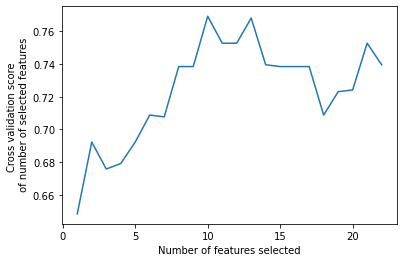

The optimal number of features is 10
The selected features are:
['prctile5', 'max', 'MAD', 'meanci_1', 'meanci_2', 'Diff_median_of_plot', 'median_second_ring', 'median_third_ring', 'median_core', 'CWSI_minus_CWSI_of_row']
Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected False, Rank: 11.000
Column: 3, Selected False, Rank: 6.000
Column: 4, Selected False, Rank: 5.000
Column: 5, Selected False, Rank: 3.000
Column: 6, Selected False, Rank: 13.000
Column: 7, Selected False, Rank: 12.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected False, Rank: 7.000
Column: 13, Selected False, Rank: 8.000
Column: 14, Selected False, Rank: 2.000
Column: 15, Selected False, Rank: 10.000
Column: 16, Selected False, Rank: 9.000
Column: 17, Selected True, Rank: 1.000
Column: 18, Selected True, Rank: 1.000
Column: 19, Selected True, Rank:

In [22]:
import random
random.seed(10)
features = RFECV_Random_Forest(data_train.drop(vars_to_drop,axis=1),data_labels_train['Type'])



In [23]:
features = ['prctile5', 'max', 'MAD', 'meanci_1', 'meanci_2', 'Diff_median_of_plot', 'median_second_ring', 'median_third_ring', 'median_core', 'CWSI_minus_CWSI_of_row']

In [24]:
data_labels_train

,Type
265,Clog
266,Clog
267,Clog
268,Clog
269,Clog
...,...
531,Control
532,Control
533,Control
534,Control


In [25]:
ml_results,best_models,metrics_results = conduct_tunning_and_classification_for_each_family_model_CV(data_train[features],
                                                                                                     data_labels_train['Type'],
                                                                                                     stage='')

DecisionTree
DT _results_summary was created
RandomForest
RF _results_summary was created
NaiveBayes
Naive Bayes _results_summary was created
KNN
KNN _results_summary was created
svm_linear
svm_linear _results_summary was created
svm_rbf
svm_rbf _results_summary was created
svm_poly
svm_poly _results_summary was created


In [27]:
best_models

Algorithm,DT,RF,Naive Bayes,KNN,svm_linear,svm_rbf,svm_poly
model_index,19,97,1,73,4,12,35
MCC,0.397293,0.465117,0.274096,0.343351,0.034416,0.283967,0.32314
ACC,0.695824,0.730769,0.655385,0.69011,0.537143,0.651209,0.618901
F1score,0.737714,0.765393,0.727888,0.771246,0.600399,0.702091,0.593735
F2score,0.73323,0.750387,0.758632,0.831014,0.599127,0.704275,0.522207
FNR,0.26389,0.255,0.21667,0.12167,0.39611,0.29167,0.51444
FPR,0.36533,0.288,0.536,0.59467,0.56267,0.43333,0.17067
FNR_Leak,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FNR_Clog,0.26389,0.255,0.21667,0.12167,0.39611,0.29167,0.51444
FPR_Leak,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
results = init_metrics()
Algorithm = 'Random Forest'
params = {'n_estimators': 500, 'criterion': 'entropy', 'min_samples_split': 15, 'bootstrap': True, 'max_depth': 10}
classifier = RandomForestClassifier(random_state=12,class_weight='balanced', n_estimators=500,
                                                            max_depth=10, criterion='entropy',min_samples_split=15,bootstrap=True)  # class_weight: misclassifying the rare class is punished harsher.
                                           
classifier.fit(data_train[features],data_labels_train['Type'])
y_prediction = classifier.predict(data_test[features])
results = calculate_metrics(Algorithm,data_labels_test,y_prediction,results)
results_summary = pd.DataFrame([[Algorithm,*list(params.values()),
                                      results['FNR'][Algorithm], results['FPR'][Algorithm],
                                     results['MCC'][Algorithm], results['ACC'][Algorithm],
                                     results['F1score'][Algorithm], results['F2score'][Algorithm]]],
            columns=['Algorithm',*list(params.keys()),'FNR','FPR', 'MCC', 'ACC','F1score','F2score'])

results_summary

,Algorithm,n_estimators,criterion,min_samples_split,bootstrap,max_depth,FNR,FPR,MCC,ACC,F1score,F2score
0,Random Forest,500,entropy,15,True,10,"{'FNR': 0.3009950248756219, 'Leak': 0.29139072...","{'FPR': 0.47440273037542663, 'Leak': 0.0, 'Clo...",0.226814,0.625899,0.683698,0.692801
